In [29]:
from mido import MidiFile
import mido
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d



In [160]:
import math 

class Oscillator:
    def __init__(self, freq=440, phase=0, amp=1, sample_rate=44100, wave_range=(-1, 1)):
        self._freq = freq
        self._amp = amp
        self._phase = phase
        self._sample_rate = sample_rate
        self._wave_range = wave_range
        
        self._f = freq
        self._a = amp
        self._p = phase
        
    def init_freq(self):
        return self._freq
    
    def init_amp(self):
        return self._amp
    
    def init_phase(self):
        return self._phase
    
    def get_freq(self):
        return self._f
    
    def set_freq(self, value):
        self._f = value
        self._post_freq_set()
        
    def get_amp(self):
        return self._a
    
    def set_amp(self, value):
        self._a = value
        
    def get_phase(self):
        return self._p
    
    def set_phase(self, value):
        self._p = value
        self._post_phase_set()
        
    def squish_val(val, min_val=0, max_val=1):
        return (((val + 1) / 2 ) * (max_val - min_val)) + min_val
        
    
class SineOscillator(Oscillator):
    def __init__(self, freq=440, phase=0, amp=1, sample_rate=44100, wave_range=(-1, 1)):
        super().__init__(freq,phase,amp,sample_rate,wave_range)
        
    def _post_freq_set(self):
        self._step = (2 * math.pi * self._f) / self._sample_rate
    
    def _post_phase_set(self):
        self._p = (self._p / 360) * 2 * math.pi

    def _initialize_osc(self):
        self._i = 0

    def __iter__(self):
        self.freq = self._freq
        self.phase = self._phase
        self.amp = self._amp
        self._initialize_osc()
        return self
    
    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = self._i + self._step
        if self._wave_range is not (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a
    
    
class SquareOscillator(SineOscillator):
    def __init__(self, freq=440, phase=0, amp=1, sample_rate=44100, wave_range=(-1, 1), threshold=0):
        super().__init__(freq, phase, amp, sample_rate, wave_range)
        self.threshold = threshold
    
    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = self._i + self._step
        if val < self.threshold:
            val = self._wave_range[0]
        else:
            val = self._wave_range[1]
        return val * self._a
    
class SawtoothOscillator(Oscillator):
    def __init__(self, freq=440, phase=0, amp=1, sample_rate=44100, wave_range=(-1, 1)):
        super().__init__(freq,phase,amp,sample_rate,wave_range)
       
    def _post_freq_set(self):
        self._period = self._sample_rate / self._f
        self._post_phase_set
        
    def _post_phase_set(self):
        self._p = ((self._p + 90)/ 360) * self._period
    
    def _initialize_osc(self):
        self._i = 0
    
    def __next__(self):
        div = (self._i + self._p )/self._period
        val = 2 * (div - math.floor(0.5 + div))
        self._i = self._i + 1
        if self._wave_range is not (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a
    
    
class TriangleOscillator(SawtoothOscillator):
    def __next__(self):
        div = (self._i + self._p)/self._period
        val = 2 * (div - math.floor(0.5 + div))
        val = (abs(val) - 0.5) * 2
        self._i = self._i + 1
        if self._wave_range is not (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a
    
    def __iter__(self):
        self.freq = self._freq
        self.phase = self._phase
        self.amp = self._amp
        self._initialize_osc()
        return self
    
    
class Sound:
    def __init__(self, sound, srate, start_time, duration):
        self.sound = sound
        self._srate = srate
        self.start_time = start_time
        self.duration = duration
        self.end_time = self.start_time+self.duration
    
    def __str__(self):
        return "start time:"+str(self.start_time)+"\nduration:"+str(self.duration)+"\nend time:"+str(self.end_time)
        


        
        
    
        
    


<>:71: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:108: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:119: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:71: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:108: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:119: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/7k/p8rkr51j1fvclhvb8tst3yhr0000gn/T/ipykernel_53769/287590965.py:71: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):
/var/folders/7k/p8rkr51j1fvclhvb8tst3yhr0000gn/T/ipykernel_53769/287590965.py:108: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):
/var/folders/7k/p8rkr51j1fvclhvb8tst3yhr0000gn/T/ipykernel_53769/287590965.py:119: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):


In [161]:
def sonify(start_msg, end_msg,tempo, A, D, S, R, wave_tp):
    note = start_msg.note
    freq = 400*2**((note-69)/12)
    
    osc = None
    if wave_tp == "sin":
        osc = SineOscillator();
    elif wave_tp == "square":
        osc = SquareOscillator();  
    elif wave_tp == "saw":
        osc = SawOscillator();
    elif wave_tp == "triangle":
        osc = TriangleOscillator();
    else:
        print("ERROR: Osclillator type not specified\nSine oscillator will be used.")
        osc = SineOscillator();
    
    osc.set_freq(freq)
    
    start_note_time = mido.tick2second(start_msg.time, tpb, tempo)
    end_note_time_before_release = mido.tick2second(end_msg.time, tpb, tempo)
    
    duration_before_release = end_note_time_before_release
    note = start_msg.note
    freq = 400*2**((note-69)/12)
    
    current_note = osc.__iter__()
    
    duration = end_note_time_before_release + R
    
    # map the attack to the (0 - 1) amplitude lvl 
    A_map = np.interp(np.linspace(0,int(A*srate),int(A*srate)),
                      np.linspace(0,int(A*srate),2), 
                      np.linspace(0,1,2))
    R_map = None
    D_map = None 
    sound = np.linspace(0,duration,math.ceil(srate*duration))
    for i in range (0,math.ceil(srate*duration)):
        if i < A*srate and i < math.ceil(end_note_time_before_release*srate): # ATTACK
            current_note.set_amp(A_map[i])
            value = current_note.__next__()
            sound[i]= value
            
        elif D_map is None:
            D_map = np.interp(np.linspace(0,math.ceil(D*srate), math.ceil(D*srate)),
                              np.linspace(0,math.ceil(D*srate), 2), 
                              np.linspace(current_note.get_amp(),S,2))
            
        elif i < (A+D)*srate and i < math.ceil(end_note_time_before_release*srate): # DECAY
            current_note.set_amp(D_map[i-int(A*srate)-1])
            value = current_note.__next__()
            sound[i]= value
        
        elif R_map is None:
            R_map = np.interp(np.linspace(0,math.ceil(R*srate), math.ceil(R*srate)),
                              np.linspace(0,math.ceil(R*srate), 2), 
                              np.linspace(current_note.get_amp(),0,2))

        elif i >= end_note_time_before_release*srate: # RELEASE 
            current_note.set_amp(R_map[i-int(end_note_time_before_release*srate)-1])
            value = current_note.__next__()
            sound[i]= value
            
        else: # SUSTAIN
            current_note.set_amp(S)
            value = current_note.__next__()
            sound[i] = value

    return sound, start_note_time, duration


def process_stem(midi,diration,srate,wave_tp,A=0.1, D=0.2, S=0.7, R=0.1):
    samples = sineOscillator.__iter__()
    notes_on = []
    sounds = []
    tempo = 0
    for i, track in enumerate(midi.tracks):
        if i == 0: # Gather Metadata
            for msg in track:
                try: 
                    tempo = msg.tempo # find tempo
                    break
                except:
                    pass
            else:
                print('ERROR: Tempo could not be found in Metadata contained in Track 0')
                
        # ------ Matching the note_off's to the note_on's to determine where each note should be played
        prev_note = None
        if i == 1: # Gather Midi notes data
            for msg in track:
                if msg.type == 'note_on':
                    notes_on.append(msg)
                    if prev_note == None:
                        prev_note = mido.tick2second(msg.time, tpb, tempo)
                if msg.type == 'note_off':
                    for i, n in enumerate(notes_on):
                        if n.note == msg.note:
                            sound, start_time, dur = sonify(notes_on[i],msg,tempo, A, D, S, R, wave_tp) # sonify
                            sounds.append(Sound(sound,srate,prev_note+start_time,dur))
                            prev_note+=start_time+dur
                            del notes_on[i]
                            break
                    else:
                        print('ERROR: no note_off for a note on.\nSynth can only process MIDI files without note overlap')       
    
    # PROCESS SYNTH: COMPUTE WAV
    t = np.zeros(math.ceil(srate*duration))
    count = 0
    for sound in sounds:
        count+=1
        start = math.ceil(sound.start_time*srate)
        end = math.floor(sound.end_time*srate)
        
        dur = end - start
        # Assigning the sounds to the correct positions in the song. If there is overflow, we cut the final note.
        try: 
            t[start:end]+=sound.sound[0:dur]
        except:
            _len = len(t[start:])
            t[start:] += sound.sound[:_len]
            pass 
        
    return t #return the synth stem



import IPython.display as ipd
vocals = MidiFile('temp_data/midi/pop.00000/vocals.mid')
drums = MidiFile('temp_data/midi/pop.00000/drums.mid')
bass = MidiFile('temp_data/midi/pop.00000/bass.mid')
other = MidiFile('temp_data/midi/pop.00000/other.mid')

tpb = vocals.ticks_per_beat

duration = vocals.length
srate = 44100      

vocal_synth = process_stem(vocals,duration,srate,'triangle',0.1,0.2,.5,.2)
ipd.Audio(vocal_synth,rate=srate)


            


/var/folders/7k/p8rkr51j1fvclhvb8tst3yhr0000gn/T/ipykernel_53769/287590965.py:71: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):
/var/folders/7k/p8rkr51j1fvclhvb8tst3yhr0000gn/T/ipykernel_53769/287590965.py:108: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):
/var/folders/7k/p8rkr51j1fvclhvb8tst3yhr0000gn/T/ipykernel_53769/287590965.py:119: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):
/var/folders/7k/p8rkr51j1fvclhvb8tst3yhr0000gn/T/ipykernel_53769/287590965.py:71: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):
/var/folders/7k/p8rkr51j1fvclhvb8tst3yhr0000gn/T/ipykernel_53769/287590965.py:108: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):
/var/folders/7k/p8rkr51j1fvclhvb8tst3yhr0000gn/T/ipykernel_53769/287590965.py:119: SyntaxWarning: "is 

TypeError: squish_val() takes from 1 to 3 positional arguments but 4 were given

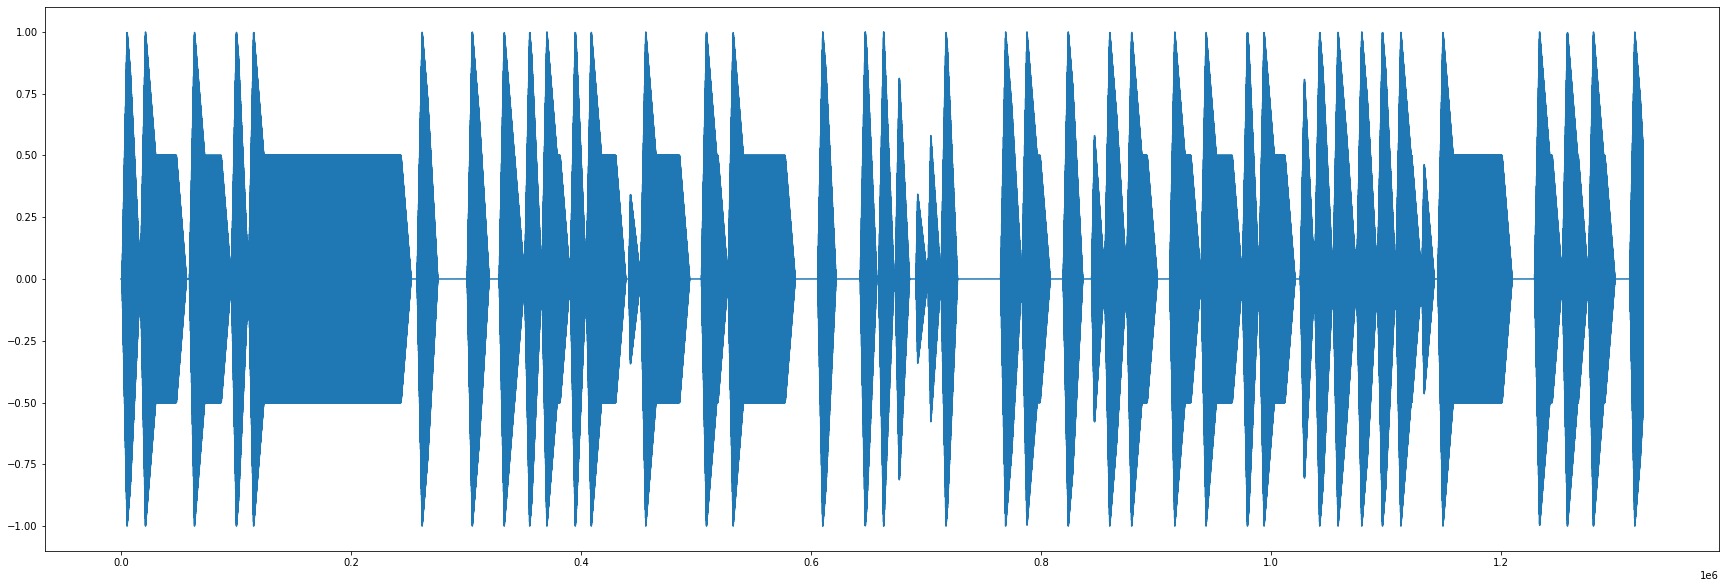

In [151]:
plt.figure(1, (30,10))
plt.plot(vocal_synth[:round(len(vocal_synth))])
plt.show()